##### Coursera
##### IBM Data Science Professional Certificate

### Capstone Project

### Determining Possible Locations For Small Businesses In Moscow As A Way to Create New Workplaces After Pandemic Time

____

##### Introduction

Due to recent situation with COVID-19 the President of Russian Federation, V. Putin instated a “non-working” period at the end of March which is to run until May 31. In many regions and precisely in Moscow strict stay-at-home orders have been in place for the last two months, however as soon as Russia’s capital city remains the most powerful and efficient in terms of economy and extremely high populated, stay-at-home measures were prolonged in the city until the June 14th. At the same time, according to “The Moscow Times” ministers told President Vladimir Putin that Russia’s economic activity has fallen by 33% since the beginning of the coronavirus pandemic. It is important to mention that Moscow - where a lot of well-known, but also small companies are located and run their daily activities - is the biggest contributor to country’s budget. But, given the actual situation, a lot of small and middle-size companies faced with unprecedented financial pressure and went bankrupt. This analysis, based on classification problem, can help individuals or households, dreaming of business set up or just trying to build small companies as a result of loosing the job, to determine, where - in other words - in which specific location in Moscow - it is a good idea to start a business or not.

In other words, I have opted for opportunity to solve the problem #2 listed in a task - identify recommendations for potential investors and businessmen if they are ready to set up a small business in Moscow as soon as a pandemic time is over. 

##### Data Available

Small companies based in Moscow always generate “flow maps” - these maps literally show businessmen places where the demand can be generated and in what particular area it is reliable and efficient to place a shop or an office. In 80% of cases the best location is an area situated nearby Moscow metro stations. This is due to the reason that undergrounds remains the most popular, fast and cheap transport in Moscow and developing actively in the last couple of years. Taking into account this fact, I am going to look at the neighborhoods surrounding underground stations and classify them. The fact is that some neighborhoods are mostly residential, some have more business or commercial spaces nearby. The venues closest to a station determine why and how people use it - the is because people in Moscow tend to buy things - be it food or service - during their path to of from the nearest to their homes or offices metro stations. 

In order to identify and accomplish my mission I have opted for a data presented on Wiki page: en.wikipedia.org/wiki/List_of_Moscow_Metro_stations. On this page you can find a complete list of Moscow Metro stations including the names, opening dates, types and, what is more important - coordinates. This is also the case why I have opted for this data: not so many sources in Moscow allow to generate latest geographical data for free. 

In addition to the data presented above I will use Foursquare API to explore venue types located nearby each station. It will show how developed or underdeveloped is an area and, as a result, what potential business direction can be set up near different Moscow metro stations.

____

##### Code Cells 

§1. Installing & Connecting Libraries 

In [1]:
get_ipython().system(u' pip install beautifulsoup4') #BeautifulSoup

     |████████████████████████████████| 122kB 14.8MB/s eta 0:00:01


In [2]:
get_ipython().system(u' pip install lxml') #Lxml

     |████████████████████████████████| 5.5MB 5.7MB/s eta 0:00:01MB/s eta 0:00:01


In [3]:
#Connecting the libraries
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [25]:
from sklearn.preprocessing import MinMaxScaler

§2. Getting the Data from Wikipedia

In [4]:
wiki = 'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations' #Getting all necessary info from Wiki
wiki1 = requests.get(wiki).text
wiki2 = BeautifulSoup(wiki1, 'lxml')
stations_table = wiki2.find('table', {'class': 'wikitable sortable'})

In [5]:
indices = [0,1,6] #From the whole table we will use the line (metro line) number, names and coordinates

stations = pd.DataFrame(columns=['Line','English Transcription','Russian Cyrillic','Coordinates'])

for tr in stations_table.find_all('tr')[1:]:
    line = re.search('#(.+?)\s', tr.find('a')['title']).group(1)
    cells = tr.find_all('td')
#Some cells do not have coordinates, so I'll ignore them as well
    if cells[6].text.strip() != '':
        stations = stations.append({
            'Line': line,
            'English Transcription': cells[0].text.strip(),
            'Russian Cyrillic': cells[1].text.strip(),
            'Coordinates': cells[6].find('span', {'class': 'geo'}).text.strip().replace('; ',',')
        }, ignore_index=True)    
        
stations.head()
stations.to_csv('stations.csv')

In [6]:
stations2 = pd.read_csv('stations.csv', index_col=0)
stations2.head(10)

,Line,English Transcription,Russian Cyrillic,Coordinates
0,1,Bulvar Rokossovskogo,Бульвар Рокоссовского,"55.8148,37.7342"
1,1,Cherkizovskaya,Черкизовская,"55.8038,37.7448"
2,1,Preobrazhenskaya Ploshchad,Преображенская площадь,"55.7963,37.7151"
3,1,Sokolniki,Сокольники,"55.7888,37.6802"
4,1,Krasnoselskaya,Красносельская,"55.7801,37.6673"
5,1,Komsomolskaya,Комсомольская,"55.7753,37.6562"
6,1,Krasnye Vorota,Красные ворота,"55.7690,37.6487"
7,1,Chistyye Prudy,Чистые пруды,"55.7657,37.6388"
8,1,Lubyanka,Лубянка,"55.7597,37.6272"
9,1,Okhotny Ryad,Охотный ряд,"55.7577,37.6166"


§3. Initializing Foursquare API

In [7]:
CLIENT_ID = 'B4T3WFAGDFMJSIYSWD4DZTELKW0B1SXDNWVMHQODOBJWMJ3B' #My Foursquare ID
CLIENT_SECRET = 'KOKGQ1XEVZENJCRH2TD5TIT51ASGOPPYPAKDC3XZQXGYNV0B' #My Foursquare Secret
VERSION = '20180604'

In [8]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [9]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


§4. Using Foursquare API it is possible to calculate the total number of venues nearby the stations

In [10]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [12]:
#Create new dataframe to store venues data
stations_venues_df = stations2.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0

In [13]:
#Request number of venues, store result as CSV
for i, row in stations_venues_df.iterrows():
    print(i)
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Coordinates.iloc[i], radius=1000, categoryId=c[1])
    stations_venues_df.to_csv('stations_venues.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


KeyError: 'totalResults'

In [57]:
#Read already stored CSV
stations_venues_df = pd.read_csv('stations_venues.csv', index_col=0)
stations_venues_df.head(20)

,Line,English Transcription,Russian Cyrillic,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,1,Bulvar Rokossovskogo,Бульвар Рокоссовского,"55.8148,37.7342",5,6,0,12,8,8,49,4,51,8
1,1,Cherkizovskaya,Черкизовская,"55.8038,37.7448",5,18,0,14,4,19,44,5,37,10
2,1,Preobrazhenskaya Ploshchad,Преображенская площадь,"55.7963,37.7151",14,22,0,34,6,30,80,14,68,15
3,1,Sokolniki,Сокольники,"55.7888,37.6802",16,17,0,53,15,43,60,25,68,19
4,1,Krasnoselskaya,Красносельская,"55.7801,37.6673",31,13,0,95,31,26,70,26,74,73
5,1,Komsomolskaya,Комсомольская,"55.7753,37.6562",33,25,1,90,19,34,85,27,59,86
6,1,Krasnye Vorota,Красные ворота,"55.7690,37.6487",47,44,1,103,38,52,103,28,68,77
7,1,Chistyye Prudy,Чистые пруды,"55.7657,37.6388",68,43,0,198,118,55,102,33,79,70
8,1,Lubyanka,Лубянка,"55.7597,37.6272",107,55,5,233,156,88,100,20,105,84
9,1,Okhotny Ryad,Охотный ряд,"55.7577,37.6166",113,80,3,125,81,93,117,19,107,71


§5. Now lets drop the vaues related to Arts & Entertainment, College & University, Residence, Travel & Transport and Event. This is an essential step for this particular analysis as if I concentrate on small businesses to be opened within Moscow.

In [58]:
stations_venues_df.drop('Arts & Entertainment', 1, inplace=True)

In [59]:
stations_venues_df.drop('College & University', 1, inplace=True)

In [60]:
stations_venues_df.drop('Residence', 1, inplace=True)

In [61]:
stations_venues_df.drop('Travel & Transport', 1, inplace=True)

In [76]:
stations_venues_df.drop('Event', 1, inplace=True)

§6. Also I had to drop these venues from categories_list

In [62]:
categories_list = list(filter(lambda x: x[0] != 'Arts & Entertainment', categories_list))

In [63]:
categories_list = list(filter(lambda x: x[0] != 'College & University', categories_list))

In [64]:
categories_list = list(filter(lambda x: x[0] != 'Residence', categories_list))

In [65]:
categories_list = list(filter(lambda x: x[0] != 'Travel & Transport', categories_list))

In [77]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

§7. Let's plot the preliminary results using a boxplot

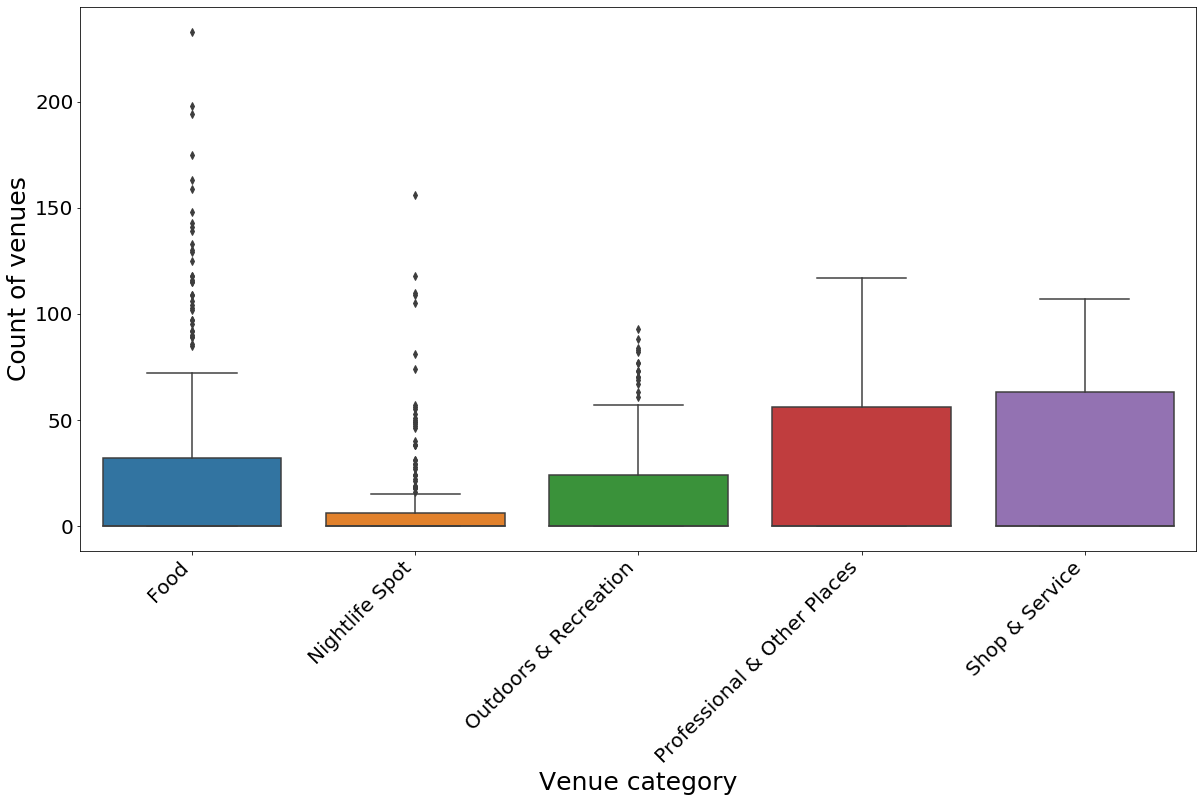

In [78]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = stations_venues_df)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

§8. Now it's time to normalize the data

In [79]:
X = stations_venues_df[['Food','Nightlife Spot', 'Outdoors & Recreation', 'Professional & Other Places', 'Shop & Service']] .values 

In [80]:
cluster_dataset = MinMaxScaler().fit_transform(X)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [97]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head(30)

,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service
0,0.051502,0.051282,0.086022,0.418803,0.476636
1,0.060086,0.025641,0.204301,0.376068,0.345794
2,0.145923,0.038462,0.322581,0.683761,0.635514
3,0.227468,0.096154,0.462366,0.512821,0.635514
4,0.407725,0.198718,0.279570,0.598291,0.691589
5,0.386266,0.121795,0.365591,0.726496,0.551402
6,0.442060,0.243590,0.559140,0.880342,0.635514
7,0.849785,0.756410,0.591398,0.871795,0.738318
8,1.000000,1.000000,0.946237,0.854701,0.981308
9,0.536481,0.519231,1.000000,1.000000,1.000000


§9. Checking the results

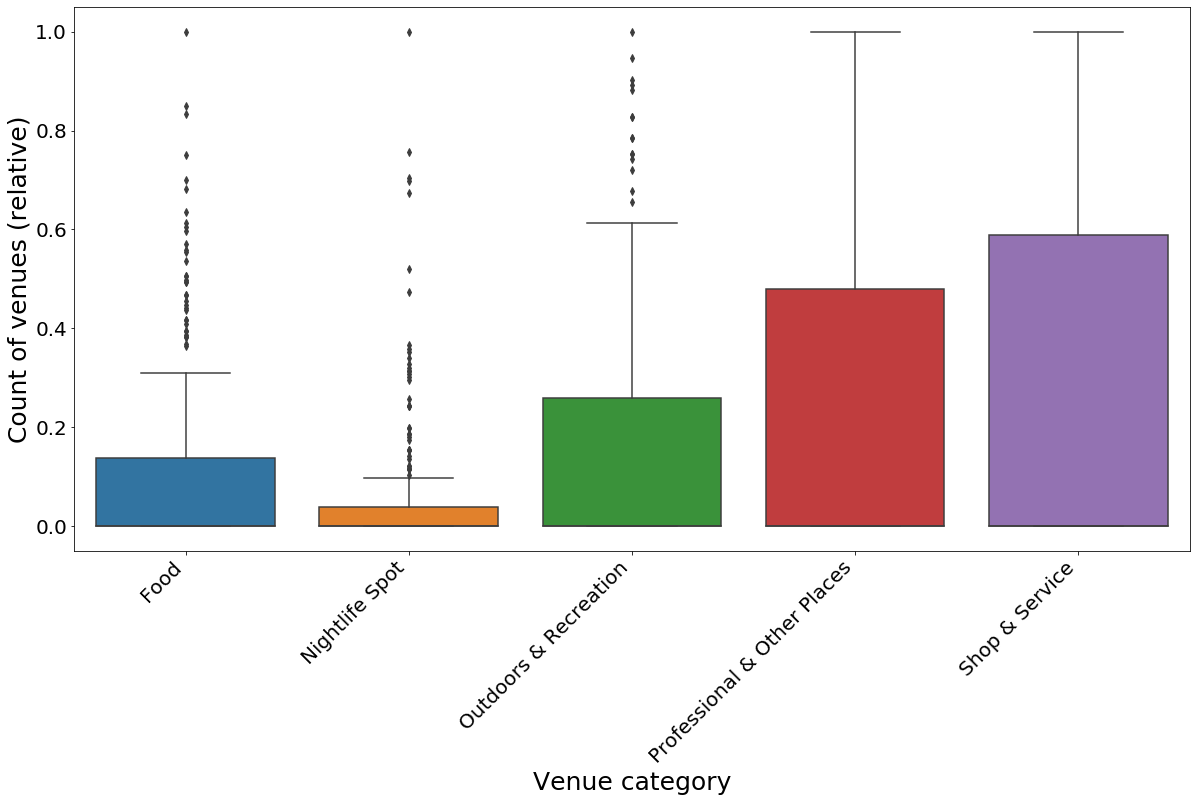

In [98]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

§10. After data normalization it's time to initiate Clustering and then add the results to a map

In [99]:
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = stations_venues_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['English Transcription'] = stations2['English Transcription']
stations_clusters_minmax_df['Coordinates'] = stations2['Coordinates']

In [102]:
map_moscow_metro = folium.Map(location=[55.755825, 37.617298], zoom_start=10)

#add markers
for i, station, coordinates, cluster in zip(stations_clusters_minmax_df.index,
                                         stations_clusters_minmax_df['English Transcription'],
                                         stations_clusters_minmax_df['Coordinates'],
                                         stations_clusters_minmax_df['Cluster']):
    latlong = [float(x) for x in coordinates.split(',')]    
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['blue','green','orange','red']
    #Calculate top 3 categories for each station
    station_series = stations_clusters_minmax_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker(
        latlong,
        fill=True,
        fill_opacity=0.5,
        popup=folium.Popup(popup, max_width = 300),
        radius=5,
        color=colors[cluster]
    ).add_to(map_moscow_metro)
    
map_moscow_metro

§11. Results

We can see different clusters shown on a map. Blue points represent the situation that different (almost all) types of venues are around nearby by an underground station - here is is not the best decision to set up business due to fierce competition. Professional and other services are the most frequent venue here. Red points shows almost the same results. Both these points are located in the city-centre, so the results are quite obvious. Green points show lower marks but reflect good scores in Shop and Service. Yellow marks represents mostly by Food category.